In [1]:
%matplotlib inline
from __future__ import division
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import struct
import pickle
import pandas as pd
import random

In [3]:
import sys
sys.path.append('../../src')

In [4]:
from pylab import rcParams
from IPython.display import clear_output
rcParams['figure.figsize'] = 16, 8
pd.options.display.max_columns = 999

In [5]:
from utils import FloatConvert32, FloatConvert64
from microssembly2 import Microssembly
from price_generator import random_walk, random_price

In [6]:
def plot_signals(observed_signal, signal):
    df = pd.DataFrame({'true': observed_signal - 0.5, 'generated': signal - 0.5}, index=observed_signal.index)
    ax = df.plot.bar()
    my_xticks = ['Sell', 'Buy']
    ax.set_yticks([-1, 1])
    ax.set_yticklabels(my_xticks)
    ax.set_xticklabels([])

In [7]:
def get_strategy_signal(price, short_ma, long_ma, demo=False):
    long_ma = abs(int(long_ma))
    shares = 1

    try:
        ml = price.rolling(long_ma).mean()

        buy = (ml > price) & (ml.shift() < price.shift())  # ma cross up
        sell = (ml < price) & (ml.shift() > price.shift())  # ma cross down
        signal = pd.Series(index=price.index)
        signal[buy[buy != False].index] = shares
        signal[sell[sell != False].index] = 0
    except Exception as e:
        print('Long {} Short {}'.format(long_ma, short_ma))
        raise e

    if demo is True:
        ax = price.plot()
        ml.plot()
        plt.legend(['price', 'Long MA'], loc='best')
        ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)

    return signal

((128,), (37,), 2005-07-23    1.0
 2005-07-25    0.0
 2005-07-27    1.0
 2005-07-29    0.0
 2005-07-30    1.0
 dtype: float64)

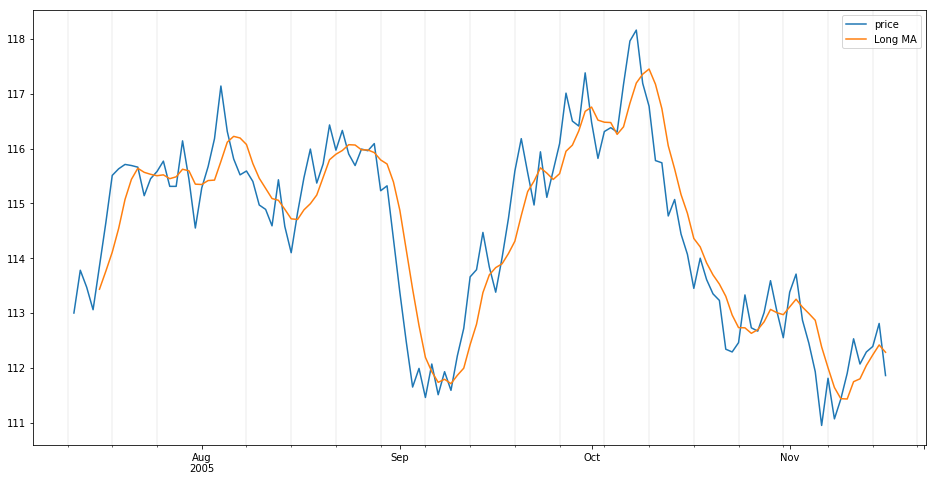

In [8]:
price = random_price()
signal = get_strategy_signal(price, 2, 5, True)
price.shape, signal.dropna().shape, signal.dropna()[:5]

In [9]:
mssembly = Microssembly(architecture = 4)
data = [1, 2, 3, 4]
mssembly.load_data(data)
mssembly.memory

array([1., 2., 3., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
prog = ([
    '110000001000',
    '001110001110',
    '110000011000',
    '001110001110',
    '110000101000',
    '001110001110',
    '110000111000',
    '001110001110',
    '101011000000',
    '101011000000',
    '101011000000',
    '101011000000',
    '010011101100',
    '110011001111' 
])
len(''.join(prog))

168

In [11]:
mssembly.run(''.join(prog), cycles=100)

['mov [0] [8]',
 'add [8] [14]',
 'mov [1] [8]',
 'add [8] [14]',
 'mov [2] [8]',
 'add [8] [14]',
 'mov [3] [8]',
 'add [8] [14]',
 'inc [12]',
 'inc [12]',
 'inc [12]',
 'inc [12]',
 'div [14] [12]',
 'mov [12] [15]']

In [12]:
assert mssembly.memory[15] == np.average(data), "Something went wrong!!!"

In [13]:
start_pop = [list(map(int, ''.join(prog).ljust(800, '0'))) for _ in range(500)]

In [14]:
from simple_strategy import get_signal, loss_function, eval_individual, find_best_model, plot_trades

In [15]:
loss = []
for _ in range(1000):
    price = random_price()
    random_code = ''.join(list(map(str, np.random.randint(0, 2, size=2000))))
    signal = get_signal(price, random_code)
    observed_signal = get_strategy_signal(price, 2, 5, False)
    l = loss_function(signal, observed_signal)    
    if(l > 0):
        loss.append(l)
print('avg\tstd\tmax\tmin')
print('{}\t{}\t{}\t{}'.format(round(np.average(loss), 3),
                              round(np.std(loss), 3),
                              round(np.max(loss), 3),
                              round(np.min(loss), 3)))

avg	std	max	min
0.0	0.0	0.0	0.0


In [ ]:
def get_strategy_signal_1(price):
    return get_strategy_signal(price, 2, 5, False)

pop, hof, _ = find_best_model(get_strategy_signal_1,
                              ngen=2000,
                              pop_size=1000,
                              mutpb=0.01,
                              indpb=0.01,
                              ind_size=800,
                              start_pop=start_pop)

gen	nevals	avg       	std        	min        	max  
0  	1000  	1.5304e-10	2.93188e-11	1.42857e-10	3e-10
1  	1021  	1.78812e-10	2.40018e-10	1.42857e-10	3e-09
2  	1002  	4.24726e-10	8.11316e-10	1.42857e-10	3e-09


In [ ]:
best_code = ''.join(map(str, hof[0]))

In [ ]:
all_loss = []
for i in range(100):
    price = random_price()
    signal = get_signal(price, best_code)
    observed_signal = get_strategy_signal_1(price)
    all_loss.append(loss_function(signal, observed_signal))
np.average(all_loss)

In [ ]:
signal.dropna()[:10]

In [ ]:
plot_signals(observed_signal, signal)

In [ ]:
import microssembly
mssembly = Microssembly(architecture=4)
mssembly.run(best_code)

In [ ]:
plot_trades(price, observed_signal, plt)
plot_trades(price + 1, signal, plt)
plt.legend(['Original signal', 'Buy', 'Sell', 'Simulated signal'], loc='best')

In [ ]:
a = (np.sum(signal[observed_signal[observed_signal == 1].index] == 1)
     / len(observed_signal[observed_signal == 1]) + 1e-9)
b = (np.sum(signal[observed_signal[observed_signal == 0].index] == 0)
     / len(observed_signal[observed_signal == 0]) + 1e-9)
c = (np.sum(np.isnan(signal[observed_signal[observed_signal.isna()].index]))
     / len(observed_signal[observed_signal.isna()]) + 1e-9)

In [ ]:
a, b, c, 3 / (1/a + 1/b + 1/c)